# Creation of the Initial Model 

## Introduction

This Notebook is develped to identify and specify the models, which will be used to apply the Active Learning strategies on. At least two models will be created, as described in the initial Research Proposal: 
1. PLS-Regression-Model 
2. Random-Forest-Regression-Model

## Preperation

To work in python, various libraries are needed. So the neccessary libraries are imported in the next cell. 

The code is developed inspired by the machine learining course by [Peter Sykacek](peter.sykacek[at]boku.ac.at) in the winter of 2023.


In [1]:
## we run locally and basepath is this directory 
basepath="./"
### ml_lib.py resides in <basepath>/course.lib and contains course relevant
### library functions. To allow loading it we set a temporary path to
### the directory
import sys  
sys.path.append(basepath+"server_files/ml_group/course.lib")

In [2]:
## timing the full notebook

import time
nb_start_time = time.time()

### Define the Path to store the ML Models 

In [3]:
import joblib

# Define the path to save the ml models

MODEL_PATH = basepath + "models"

MODEL_PATH
sys.path.append(MODEL_PATH)

### Imports

In [4]:
import ml_lib as mlib
import numpy as np
import matplotlib.pyplot as plt


### turn off convergence warnings

In [5]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
import os
os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Import Model functions

To generate various models an import of the respective functions from preexisting packages is neccessary. 

### Gridsearch Crossvalidation

[sklearn GSCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

Exhaustive search over specified parameter values for an estimator.
Important members are fit, predict.

* GridSearchCV implements a "fit" and a "score" method.
* It also implements "score_samples", "predict", "predict_proba", "decision_function", "transform" and "inverse_transform" if they are implemented in the estimator used.

In [6]:
from sklearn.model_selection import GridSearchCV as GSCV

### Randomized Parameter Optimization

[sklearn RandomizedSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)  

 RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

A budget can be chosen independent of the number of parameters and possible values.


In [7]:
from sklearn.model_selection import RandomizedSearchCV

### K-Fold cross-validator.
[sklearn KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).

Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [8]:
from sklearn.model_selection import KFold

### Kernel Ridge

[sklearn KRR](https://scikit-learn.org/stable/modules/kernel_ridge.html#kernel-ridge-regression)

Kernel ridge regression (KRR) [M2012] combines Ridge regression and classification (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space.

In [9]:
from sklearn.kernel_ridge import KernelRidge as KRR

## Model Inspection

[sklearn cv_results_](https://scikit-learn.org/stable/modules/grid_search.html#analyzing-results-with-the-cv-results-attribute)

"The cv_results_ attribute contains useful information for analyzing the results of a search. It can be converted to a pandas dataframe with df = pd.DataFrame(est.cv_results_)."

## Data Import

In this section the sample data will be imported. 

Currently 2 Datasets are of interest for us: 
1. PS20191107_gegl.csv
2. dps1200.csv

The differences are that the first is a dataframe containing the data unmodified and full. It was used to generate the later, which contains only selected sections of the spectra. The Wavelengths of this dataset were selected by discarding Wavelengths, based on critieria ???

**TODO**: Research the criteria

### PS20191107 (Full Data)

In [10]:
import pandas as pd
data_full = pd.read_csv(basepath+"data/PS20191107_gegl.csv", 
                            sep=";", decimal=",", encoding="utf-8")
print(data_full.head())

     Unnamed: 0  year Origin    type      3996      3994      3992      3990  \
0  2GOS-18_1955  1955    POL  living  0.016119  0.015972  0.015830  0.015728   
1  2GOS-18_1969  1969    POL  living  0.016368  0.016543  0.016663  0.016569   
2  2GOS-18_1974  1974    POL  living  0.021364  0.021662  0.021862  0.021573   
3  2GOS-18_1976  1976    POL  living  0.019351  0.019246  0.019181  0.018998   
4  2GOS-18_1996  1996    POL  living  0.018548  0.018604  0.018670  0.018616   

       3988      3987  ...       417       415       413       411       409  \
0  0.015734  0.015787  ... -0.027973 -0.028180 -0.028389 -0.028595 -0.029011   
1  0.016333  0.016217  ... -0.029520 -0.029747 -0.029978 -0.030204 -0.030087   
2  0.020925  0.020585  ... -0.031046 -0.031270 -0.031483 -0.031701 -0.032089   
3  0.018926  0.019205  ... -0.029852 -0.030092 -0.030361 -0.030647 -0.031115   
4  0.018375  0.018266  ... -0.029963 -0.030206 -0.030436 -0.030643 -0.030917   

        407       405       403       

#### Statistics

In [11]:
# Retrive basic characteristics for each variable
data_full.describe()

,year,3996,3994,3992,3990,3988,3987,3985,3983,3981,...,417,415,413,411,409,407,405,403,401,399
count,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,...,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000,2244.000000
mean,-152.291889,0.011321,0.011238,0.011167,0.011087,0.011004,0.010989,0.010963,0.010900,0.010838,...,-0.024586,-0.024782,-0.024978,-0.025175,-0.025414,-0.025638,-0.025847,-0.026018,-0.026165,-0.026328
std,3659.189806,0.005232,0.005231,0.005229,0.005212,0.005180,0.005176,0.005207,0.005203,0.005198,...,0.003439,0.003428,0.003417,0.003405,0.003410,0.003386,0.003367,0.003356,0.003346,0.003334
min,-13555.000000,-0.002773,-0.002953,-0.002774,-0.002312,-0.002147,-0.002444,-0.003096,-0.003154,-0.003191,...,-0.035057,-0.035212,-0.035350,-0.035504,-0.036023,-0.036370,-0.036337,-0.036325,-0.036375,-0.036506
25%,-370.250000,0.007695,0.007627,0.007587,0.007504,0.007385,0.007355,0.007297,0.007233,0.007174,...,-0.027123,-0.027286,-0.027461,-0.027654,-0.027906,-0.028134,-0.028300,-0.028394,-0.028544,-0.028711
50%,1472.500000,0.012248,0.012160,0.012073,0.011959,0.011875,0.011864,0.011888,0.011831,0.011757,...,-0.024376,-0.024564,-0.024764,-0.024939,-0.025142,-0.025372,-0.025599,-0.025777,-0.025945,-0.026034
75%,1806.000000,0.015064,0.014983,0.014875,0.014752,0.014673,0.014688,0.014675,0.014619,0.014553,...,-0.021932,-0.022128,-0.022342,-0.022558,-0.022820,-0.023040,-0.023253,-0.023459,-0.023626,-0.023843
max,2009.000000,0.028401,0.027898,0.027302,0.027014,0.026885,0.026733,0.027129,0.026971,0.026841,...,-0.013279,-0.013542,-0.013811,-0.014076,-0.014361,-0.014733,-0.015133,-0.015328,-0.015409,-0.015598


In [12]:
data_full.groupby('type')[['year']].agg(['max', 'mean', 'min'])

year                    
         max         mean    min
type                            
constr  1936  1628.966667   1239
dry     1765   948.591716    327
living  2009  1886.843700   1524
water   1912 -2682.173774 -13555

### Import dataset dps1200.csv

In [13]:
data_1200 = pd.read_csv(basepath+"data/dps1200.csv", 
                            sep=",", decimal=".", encoding="utf-8")
data_1200.head()

,Unnamed: 0,year,tree,Origin,type,X2970,X2968,X2966,X2964,X2962,...,X818,X816,X814,X812,X810,X808,X806,X804,X802,X800
0,2GOS-18_1955,1955,2GOS-18,POL,living,0.019849,0.020121,0.020414,0.020724,0.021030,...,-0.023469,-0.023367,-0.023283,-0.023220,-0.023183,-0.023174,-0.023190,-0.023228,-0.023293,-0.023388
1,2GOS-18_1969,1969,2GOS-18,POL,living,0.023933,0.024378,0.024827,0.025273,0.025712,...,-0.024117,-0.024076,-0.024043,-0.024021,-0.024015,-0.024033,-0.024077,-0.024147,-0.024238,-0.024346
2,2GOS-18_1974,1974,2GOS-18,POL,living,0.021605,0.021971,0.022342,0.022719,0.023099,...,-0.026266,-0.026214,-0.026172,-0.026149,-0.026146,-0.026165,-0.026208,-0.026273,-0.026363,-0.026479
3,2GOS-18_1976,1976,2GOS-18,POL,living,0.021999,0.022315,0.022651,0.022999,0.023345,...,-0.025113,-0.025030,-0.024959,-0.024909,-0.024885,-0.024888,-0.024918,-0.024971,-0.025049,-0.025153
4,2GOS-18_1996,1996,2GOS-18,POL,living,0.021031,0.021338,0.021626,0.021923,0.022248,...,-0.025256,-0.025158,-0.025083,-0.025035,-0.025013,-0.025015,-0.025040,-0.025094,-0.025177,-0.025282


In [14]:
# Correct the column headers

# data_1200.rename(lambda x: x[1:], axis='columns')
data_1200 = data_1200.rename(columns=lambda x: x.replace('X', ''))

In [15]:
data_1200.describe()
# describe() gives some basic statistics for numeric columns,

,year,2970,2968,2966,2964,2962,2960,2959,2957,2955,...,818,816,814,812,810,808,806,804,802,800
count,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,...,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000
mean,1740.420930,0.018827,0.019122,0.019427,0.019740,0.020061,0.020389,0.020728,0.021078,0.021439,...,-0.020705,-0.020572,-0.020456,-0.020361,-0.020292,-0.020254,-0.020248,-0.020276,-0.020335,-0.020420
std,196.420289,0.001922,0.001978,0.002038,0.002100,0.002163,0.002223,0.002279,0.002333,0.002385,...,0.002526,0.002560,0.002593,0.002622,0.002649,0.002673,0.002693,0.002710,0.002723,0.002735
min,1194.000000,0.011339,0.011597,0.011871,0.012159,0.012466,0.012791,0.013134,0.013493,0.013861,...,-0.026419,-0.026362,-0.026319,-0.026296,-0.026293,-0.026308,-0.026335,-0.026373,-0.026451,-0.026601
25%,1616.000000,0.017552,0.017789,0.018044,0.018325,0.018587,0.018869,0.019175,0.019468,0.019784,...,-0.022815,-0.022723,-0.022603,-0.022533,-0.022505,-0.022469,-0.022500,-0.022531,-0.022616,-0.022704
50%,1769.000000,0.018673,0.018942,0.019230,0.019521,0.019805,0.020112,0.020430,0.020781,0.021118,...,-0.020678,-0.020497,-0.020383,-0.020287,-0.020214,-0.020141,-0.020116,-0.020118,-0.020152,-0.020231
75%,1913.000000,0.019991,0.020269,0.020567,0.020911,0.021258,0.021605,0.021966,0.022307,0.022655,...,-0.018458,-0.018294,-0.018154,-0.018033,-0.017950,-0.017888,-0.017871,-0.017885,-0.017919,-0.017988
max,2009.000000,0.027378,0.028247,0.029124,0.029990,0.030832,0.031645,0.032436,0.033220,0.034017,...,-0.013677,-0.013408,-0.013178,-0.012991,-0.012843,-0.012738,-0.012686,-0.012691,-0.012745,-0.012844


In [16]:
data_1200.describe(include="object")
# describe() gives some basic statistics for numeric columns, 
# categorial columns are included with the option include="object"

,Unnamed: 0,tree,Origin,type
count,1290,1290,1290,1290
unique,1290,139,4,4
top,SZLPS15a_1982,Dev2b,AUT,living
freq,1,29,631,627


# Visualisation

# Basic Models (Full dataset)

Creation of Models with the full dataset

In [17]:
# Define a random state

random_state = np.random.RandomState(202375)

# Split of the full dataset (data_full)

# For this we will Split the Full data in Training in Test Data

# the predictors need to be all variables except the categorial variables 
# X = data_full.drop('year', axis=1, )
X = data_full.select_dtypes('float')

y = data_full['year']

from sklearn.model_selection import train_test_split
# Split the dataset into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [18]:
X.head()

,3996,3994,3992,3990,3988,3987,3985,3983,3981,3979,...,417,415,413,411,409,407,405,403,401,399
0,0.016119,0.015972,0.015830,0.015728,0.015734,0.015787,0.015697,0.015633,0.015576,0.015525,...,-0.027973,-0.028180,-0.028389,-0.028595,-0.029011,-0.029123,-0.029323,-0.029610,-0.029759,-0.029746
1,0.016368,0.016543,0.016663,0.016569,0.016333,0.016217,0.016152,0.016069,0.015989,0.015906,...,-0.029520,-0.029747,-0.029978,-0.030204,-0.030087,-0.030284,-0.030746,-0.031163,-0.031519,-0.031815
2,0.021364,0.021662,0.021862,0.021573,0.020925,0.020585,0.021042,0.020978,0.020886,0.020765,...,-0.031046,-0.031270,-0.031483,-0.031701,-0.032089,-0.032390,-0.032609,-0.032653,-0.032627,-0.032784
3,0.019351,0.019246,0.019181,0.018998,0.018926,0.019205,0.018914,0.018838,0.018755,0.018679,...,-0.029852,-0.030092,-0.030361,-0.030647,-0.031115,-0.031281,-0.031376,-0.031721,-0.032172,-0.032433
4,0.018548,0.018604,0.018670,0.018616,0.018375,0.018266,0.018447,0.018423,0.018395,0.018378,...,-0.029963,-0.030206,-0.030436,-0.030643,-0.030917,-0.031127,-0.031338,-0.031409,-0.031364,-0.031465


In [19]:
y.head()

0    1955
1    1969
2    1974
3    1976
4    1996
Name: year, dtype: int64

### Plot the spectra

In [20]:
# data_full['3996'].head()
x_plot = list(data_full.columns.values[4:])
y_plot = data_full.loc[:, x_plot]
y_plot

,3996,3994,3992,3990,3988,3987,3985,3983,3981,3979,...,417,415,413,411,409,407,405,403,401,399
0,0.016119,0.015972,0.015830,0.015728,0.015734,0.015787,0.015697,0.015633,0.015576,0.015525,...,-0.027973,-0.028180,-0.028389,-0.028595,-0.029011,-0.029123,-0.029323,-0.029610,-0.029759,-0.029746
1,0.016368,0.016543,0.016663,0.016569,0.016333,0.016217,0.016152,0.016069,0.015989,0.015906,...,-0.029520,-0.029747,-0.029978,-0.030204,-0.030087,-0.030284,-0.030746,-0.031163,-0.031519,-0.031815
2,0.021364,0.021662,0.021862,0.021573,0.020925,0.020585,0.021042,0.020978,0.020886,0.020765,...,-0.031046,-0.031270,-0.031483,-0.031701,-0.032089,-0.032390,-0.032609,-0.032653,-0.032627,-0.032784
3,0.019351,0.019246,0.019181,0.018998,0.018926,0.019205,0.018914,0.018838,0.018755,0.018679,...,-0.029852,-0.030092,-0.030361,-0.030647,-0.031115,-0.031281,-0.031376,-0.031721,-0.032172,-0.032433
4,0.018548,0.018604,0.018670,0.018616,0.018375,0.018266,0.018447,0.018423,0.018395,0.018378,...,-0.029963,-0.030206,-0.030436,-0.030643,-0.030917,-0.031127,-0.031338,-0.031409,-0.031364,-0.031465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,0.014997,0.014860,0.014757,0.014833,0.014941,0.014999,0.014709,0.014662,0.014622,0.014573,...,-0.027377,-0.027558,-0.027725,-0.027886,-0.028042,-0.028378,-0.028779,-0.028877,-0.028665,-0.028689
2240,0.018888,0.018707,0.018463,0.018349,0.018346,0.018399,0.018357,0.018265,0.018188,0.018126,...,-0.028778,-0.028969,-0.029163,-0.029343,-0.029310,-0.029607,-0.029862,-0.029956,-0.030134,-0.030310
2241,0.009736,0.009731,0.009534,0.009123,0.008829,0.008916,0.009195,0.009097,0.008992,0.008902,...,-0.021724,-0.021944,-0.022158,-0.022368,-0.022615,-0.022865,-0.023479,-0.023823,-0.023572,-0.023163
2242,0.008178,0.008050,0.007871,0.007529,0.007205,0.007323,0.007898,0.007857,0.007815,0.007781,...,-0.019306,-0.019636,-0.019983,-0.020321,-0.020375,-0.020890,-0.021583,-0.022251,-0.022595,-0.022824


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


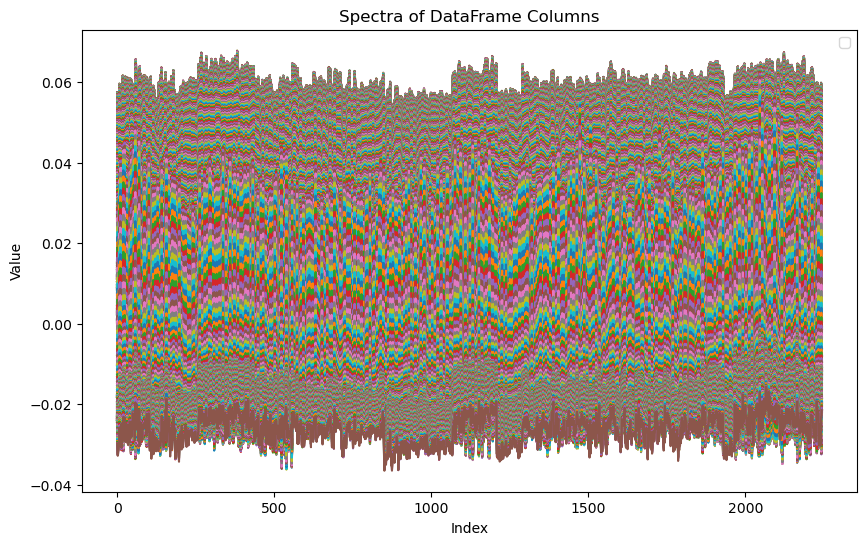

In [21]:
# Create a new figure
plt.figure(figsize=(10, 6)) # Adjust the figure size as needed

# Plot each numeric column against its header value
# for column in numeric_columns:
#    plt.plot(data_full[column], label=column)
plt.plot(data_full[data_full.columns[4:]])

# Set labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Spectra of DataFrame Columns')

# Add a legend
plt.legend()

# Show the plot
plt.show()


The above spectra hints at a mean centered preprocessing done previously (?)

### Defining CV and Score metrics

[sklearn make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer)

Make a scorer from a performance metric or loss function.  
A scorer is a wrapper around an arbitrary metric or loss function that is called with the signature scorer(estimator, X, y_true, **kwargs).  
It is accepted in all scikit-learn estimators or functions allowing a scoring parameter.

In [22]:
from sklearn.metrics import make_scorer  
from sklearn.metrics import mean_squared_error
# Whether score_func is a score function (default), or
# a loss function depenend on the prevered value of the scorer
gcv_scorer=make_scorer(mean_squared_error, greater_is_better=False)


# Define the parameters for the CV

testing = False
######################################################
if testing == True:
    nfolds = 2
    NoTrials = 5
    n_jobs = -1
    save_model = False
    print("Testing mode for Cross Validation")
else:
    nfolds = 10
    NoTrials = 15
    n_jobs = 20
    save_model = True
    print("Extensive mode for Cross Validation")
######################################################

Extensive mode for Cross Validation


In [23]:
# Investigate the number of available CPUs to work with
import os

# Get the number of CPUs
num_cpus = os.cpu_count()
num_cpus

80

## Random Forest

In [24]:
from sklearn import metrics as sklearn_metrics
from sklearn.model_selection import cross_val_predict as cvp
import matplotlib.pyplot as plt
import numpy as np

### Random Forest Basic Model: 

sklearn.ensemble.RandomForestRegressor(n_estimators=100, 
                                       *, 
                                       criterion='squared_error',
                                         max_depth=None, 
                                         min_samples_split=2, 
                                         min_samples_leaf=1, 
                                         min_weight_fraction_leaf=0.0, 
                                         max_features=1.0, 
                                         max_leaf_nodes=None, 
                                         min_impurity_decrease=0.0, 
                                         bootstrap=True, 
                                         oob_score=False, 
                                         n_jobs=None, 
                                         random_state=None, 
                                         verbose=0, 
                                         warm_start=False, 
                                         ccp_alpha=0.0, 
                                         max_samples=None, 
                                         monotonic_cst=None)




##### Span testing grid

In [25]:
#Start the timer
start_time = time.time()

# Create the parameter grid

p_grid_rf = {
    # Number of trees in the forest
    "n_estimators": [25, 50, 100],
    "min_samples_split": [5, 10],
    # "min_samples_leaf": [1, 2, 4], 
}

# Import the  Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

# empty lists for the optimal parameters
all_opt_rf_n_estimators=[]

# Instantiate the CV object
mnsqrerr_one_cv_layer=np.zeros((NoTrials, 1))
mnsqrerr_two_cv_layers=np.zeros((NoTrials, 1))

# Save the predictions
all_predictions=np.zeros((len(y_train),NoTrials))

for i in range(0,2):
    print("Sim: {0}".format(i))

    # Split the data into 'nfolds' number of splits 
    inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
    
    # define the model
    cv_rf = GSCV(estimator=rf, param_grid=p_grid_rf, cv=inner_cv, 
                      scoring=gcv_scorer, n_jobs=n_jobs, verbose=1)
    
    # fit the model
    cv_rf.fit(X_train, y_train)

    # get the optimal parameters
    all_opt_rf_n_estimators.append(cv_rf.cv_results_['param_n_estimators'][cv_rf.best_index_])
    
    # perform outer cv
    mnsqrerr_one_cv_layer[i] = cv_rf.best_score_
    y_pred = cvp(cv_rf, X=X_train, y=y_train, cv=outer_cv, n_jobs=n_jobs)
    all_predictions[:,i]=y_pred #[:,0]
    mnsqrerr_two_cv_layers[i] = mean_squared_error(y_train, y_pred)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")


Sim: 0
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Sim: 1
Fitting 10 folds for each of 6 candidates, totalling 60 fits


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Execution time: 3822.1757106781006 seconds


#### Old Investigation

In [26]:
cv_rf.best_params_

{'min_samples_split': 5, 'n_estimators': 50}

In [27]:
cvres = cv_rf.cv_results_

# cvres

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1518.2335238791911 {'min_samples_split': 5, 'n_estimators': 25}
1515.4699354043316 {'min_samples_split': 5, 'n_estimators': 50}
1517.5638948604064 {'min_samples_split': 5, 'n_estimators': 100}
1525.4730937909399 {'min_samples_split': 10, 'n_estimators': 25}
1522.3857373849073 {'min_samples_split': 10, 'n_estimators': 50}
1525.039146906438 {'min_samples_split': 10, 'n_estimators': 100}


In [28]:
# calculate difference between the outer and inner CV

score_difference = mnsqrerr_two_cv_layers - mnsqrerr_one_cv_layer
score_difference
# return the parameters
params = cv_rf.get_params() #Get parameters for this estimator.
params

# runtime for pgrid (1x3) and 5 fold 20 Trial:  48 min 
# runtime for pgrid (3x4) and 5 fold 10 Trial:  52 min
    # Fitting 5 folds for each of 12 candidates, totalling 60 fits
# runtime for pgrid (5x3) and 5 fold 10 Trial:  54 min
    # Fitting 5 folds for each of 15 candidates, totalling 75 fits

{'cv': KFold(n_splits=10, random_state=1, shuffle=True),
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(),
 'n_jobs': -1,
 'param_grid': {'n_estimators': [25, 50, 100], 'min_samples_split': [5, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': make_scorer(mean_squared_error, greater_is_better=False),
 'verbose': 1}

In [29]:
# mnsqrerr_one_cv_layer
# mnsqrerr_two_cv_layers

score_difference

array([[4454280.83275541],
       [4536270.15751109],
       [      0.        ],
       [      0.        ],
       [      0.        ],
       [      0.        ],
       [      0.        ],
       [      0.        ],
       [      0.        ],
       [      0.        ],
       [      0.        ],
       [      0.        ],
       [      0.        ],
       [      0.        ],
       [      0.        ]])

#### RF Results

To interpret the results of the Model (RF) we will investigate the model parameters and plot some of the results. 

In [30]:
cv_rf.param_grid

# print(all_opt_rf_n_estimators)

{'n_estimators': [25, 50, 100], 'min_samples_split': [5, 10]}

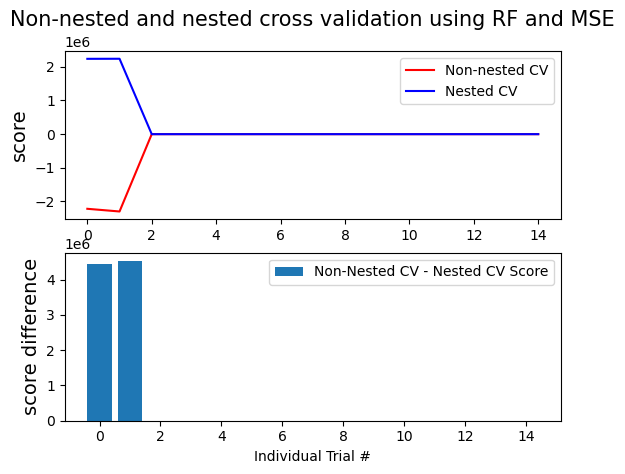

In [31]:
## Results RF Regressor

myfig=plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(mnsqrerr_one_cv_layer, color='r')
nested_line, =plt.plot(mnsqrerr_two_cv_layers, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-nested CV", "Nested CV"],
            #bbox_to_anchor=(0, .4, .5, 0),
            loc=0)
plt.title("Non-nested and nested cross validation using RF and MSE",
          x=.5, y=1.1, fontsize="15")
plt.subplot(212)
difference_plot=plt.bar(range(NoTrials), score_difference[:,0])
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           #bbox_to_anchor=(0,1,.8,0)
            loc=0)
plt.ylabel("score difference", fontsize="14")
plt.show()

#### Extract the optimal Parameters

In [32]:
scores_rf = cv_rf.cv_results_['mean_test_score']
scores_rf_std = cv_rf.cv_results_['std_test_score']
alphas = cv_rf.cv_results_['param_n_estimators']

In [33]:
# extract the values for the grid

cv_rf.cv_results_

{'mean_fit_time': array([ 72.29513669, 131.08880618, 249.0877197 ,  66.80293591,
        119.68266313, 231.28926988]),
 'std_fit_time': array([4.9921199 , 6.66878712, 6.45058848, 4.35676894, 6.01477359,
        6.82601463]),
 'mean_score_time': array([0.02608781, 0.02844324, 0.03302658, 0.02369339, 0.02745082,
        0.0317898 ]),
 'std_score_time': array([0.00172436, 0.0036908 , 0.00319468, 0.00091829, 0.00403871,
        0.00438609]),
 'param_min_samples_split': masked_array(data=[5, 5, 5, 10, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[25, 50, 100, 25, 50, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_samples_split': 5, 'n_estimators': 25},
  {'min_samples_split': 5, 'n_estimators': 50},
  {'min_samples_split': 5, 'n_estimators': 100},
  {'min_samples_split': 10, 'n_esti

In [34]:
scores_rf

array([-2305033.03303063, -2296649.12511441, -2303000.17498389,
       -2327068.1598801 , -2317658.33339299, -2325744.39959712])

In [35]:
scores_rf_std

array([706021.07961129, 773497.01332942, 799418.12843464, 843777.34053748,
       944099.98934479, 806507.01708655])

In [36]:
alphas # masked array, where all values are true

masked_array(data=[25, 50, 100, 25, 50, 100],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object)

In [37]:
alphas.data

array([25, 50, 100, 25, 50, 100], dtype=object)

(25.0, 100.0)

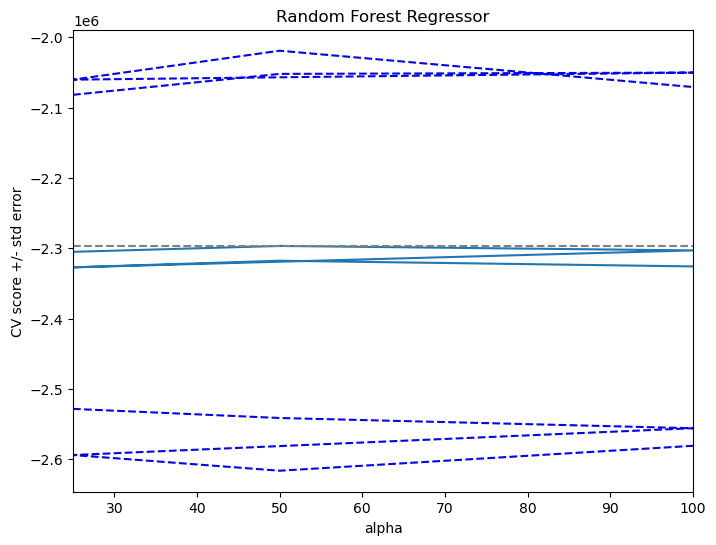

In [38]:
# plot the quality of the models and identify the parameters of the best one

plt.figure().set_size_inches(8, 6)
plt.plot(alphas.data, scores_rf) 

# plot error lines showing +/- std. errors of the scores
std_error = scores_rf_std / np.sqrt(nfolds)

plt.plot(alphas.data, scores_rf + std_error, 'b--')
plt.plot(alphas.data, scores_rf - std_error, 'b--')

# Add labels

plt.title("Random Forest Regressor")
plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axhline(np.max(scores_rf), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])

#### Result Vizualisation

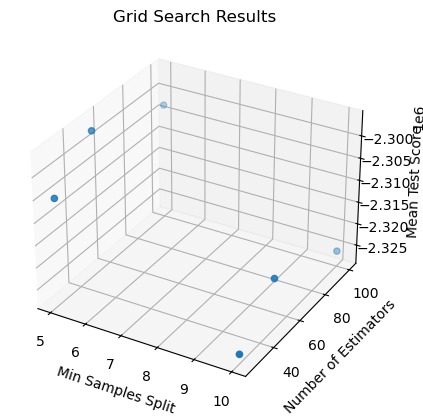

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming cv_rf is your GridSearchCV object
param_min_samples_split = cv_rf.cv_results_['param_min_samples_split']
param_n_estimators = cv_rf.cv_results_['param_n_estimators']
mean_test_score = cv_rf.cv_results_['mean_test_score']

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(param_min_samples_split, param_n_estimators, mean_test_score)

# Set labels
ax.set_xlabel('Min Samples Split')
ax.set_ylabel('Number of Estimators')
ax.set_zlabel('Mean Test Score')

# Set title
ax.set_title('Grid Search Results')

# Show the plot
plt.show()


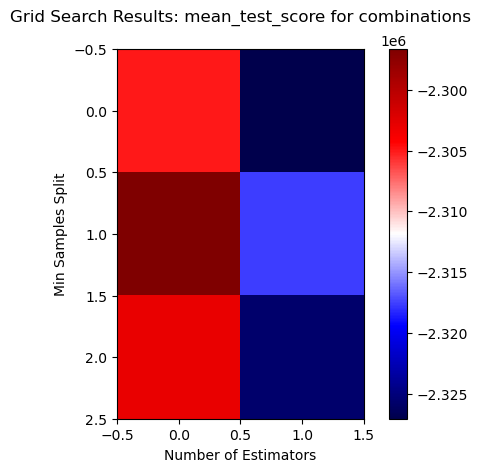

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming cv_rf is your GridSearchCV object
param_min_samples_split = cv_rf.cv_results_['param_min_samples_split']
param_n_estimators = cv_rf.cv_results_['param_n_estimators']
mean_test_score = cv_rf.cv_results_['mean_test_score']

# Create a 2D grid of the parameters
min_samples_split_grid, n_estimators_grid = np.meshgrid(np.unique(param_min_samples_split), np.unique(param_n_estimators))

# Interpolate the mean test scores for each combination of parameters
heatmap_data = np.array([mean_test_score[np.where((param_min_samples_split == ms) & (param_n_estimators == ne))[0][0]] for ms, ne in zip(np.ravel(min_samples_split_grid), np.ravel(n_estimators_grid))])
heatmap_data = heatmap_data.reshape(min_samples_split_grid.shape)

# Create the heatmap
# plt.figure(figsize=(8, 10))
plt.imshow(heatmap_data, cmap='seismic', interpolation='nearest')

# Set labels
plt.xlabel('Number of Estimators')
plt.ylabel('Min Samples Split')
plt.title('Grid Search Results: mean_test_score for combinations', pad = 20)
plt.colorbar()

# plt.axis.Axis('')

# Show the plot
plt.show()

In [41]:
cv_rf.cv_results_['param_n_estimators'][cv_rf.best_index_]

50

In [42]:
X_test

,3996,3994,3992,3990,3988,3987,3985,3983,3981,3979,...,417,415,413,411,409,407,405,403,401,399
2013,0.002643,0.002448,0.001910,0.001642,0.001821,0.002004,0.001839,0.001714,0.001588,0.001511,...,-0.018427,-0.018693,-0.018922,-0.019134,-0.020094,-0.020658,-0.020751,-0.020409,-0.020143,-0.020191
2009,0.005888,0.005793,0.005823,0.005876,0.005874,0.005908,0.005810,0.005789,0.005757,0.005708,...,-0.022418,-0.022572,-0.022714,-0.022854,-0.022945,-0.023158,-0.023355,-0.023393,-0.023345,-0.023321
1481,0.012567,0.012300,0.012057,0.011926,0.011902,0.011999,0.011971,0.011873,0.011796,0.011747,...,-0.023590,-0.023773,-0.023935,-0.024090,-0.024448,-0.024786,-0.024968,-0.024905,-0.024789,-0.024844
1247,0.017977,0.017948,0.017901,0.017753,0.017580,0.017478,0.017629,0.017561,0.017479,0.017392,...,-0.030780,-0.030963,-0.031140,-0.031310,-0.031527,-0.031653,-0.031813,-0.031934,-0.032091,-0.032297
1772,0.015090,0.014866,0.014648,0.014602,0.014682,0.014737,0.014691,0.014645,0.014602,0.014561,...,-0.025160,-0.025324,-0.025474,-0.025623,-0.025871,-0.026258,-0.026453,-0.026429,-0.026377,-0.026433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,0.014824,0.015011,0.015275,0.015505,0.015365,0.014691,0.014491,0.014389,0.014269,0.014157,...,-0.024147,-0.024381,-0.024593,-0.024791,-0.025493,-0.025727,-0.025761,-0.025875,-0.026023,-0.026013
1015,0.018076,0.017919,0.017858,0.017803,0.017743,0.017818,0.017800,0.017729,0.017665,0.017605,...,-0.029071,-0.029188,-0.029313,-0.029455,-0.029823,-0.030029,-0.029943,-0.029906,-0.030122,-0.030418
1593,0.010863,0.010733,0.010733,0.010816,0.010820,0.010803,0.010671,0.010613,0.010559,0.010490,...,-0.024413,-0.024598,-0.024778,-0.024973,-0.025430,-0.025715,-0.025860,-0.025859,-0.025814,-0.026052
1660,0.010711,0.010833,0.010857,0.010769,0.010833,0.010960,0.010516,0.010461,0.010386,0.010277,...,-0.018803,-0.019050,-0.019320,-0.019581,-0.019432,-0.019692,-0.020131,-0.020608,-0.021046,-0.021174


#### RF with Randomized Search

Following the Strategy from ["Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd edition)"](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) to implement a RandomSearchCV from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html#sklearn.model_selection.HalvingRandomSearchCV). 



In [43]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV

In [44]:
start_time = time.time()
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'n_estimators': randint(low=3, high=100), # for hyperparameter with discrete values 
                  'min_samples_split': randint(low=2, high=20)}

rf_rnd_search = RandomizedSearchCV(
    rf, param_distributions=param_distribs, n_iter=10, cv=inner_cv,
    scoring=gcv_scorer, random_state=random_state, verbose=1, n_jobs=n_jobs)
    
    # fit the model
rf_rnd_search.fit(X_train, y_train)

end_time = time.time()
execution_time = (end_time - start_time)/60
print(f"Execution time: {execution_time} minutes")



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Execution time: 471.16307973861694 seconds


In [45]:
rf_rnd_results = pd.DataFrame(rf_rnd_search.cv_results_)
rf_rnd_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
4,241.962947,3.222332,0.028836,0.000597,6,87,"{'min_samples_split': 6, 'n_estimators': 87}",-1.100159e+06,-1.900893e+06,-3.382449e+06,-1.465037e+06,-2.302010e+06,-3.627882e+06,-1.591338e+06,-1.721281e+06,-1.933986e+06,-3.437921e+06,-2.246296e+06,864184.319945,1
0,162.241217,1.957601,0.029805,0.004453,9,55,"{'min_samples_split': 9, 'n_estimators': 55}",-1.128899e+06,-1.857027e+06,-3.447965e+06,-1.489840e+06,-2.274269e+06,-3.540906e+06,-1.645599e+06,-1.811155e+06,-1.899842e+06,-3.713112e+06,-2.280861e+06,888985.719440,2
2,207.739327,3.946675,0.029902,0.004383,9,76,"{'min_samples_split': 9, 'n_estimators': 76}",-1.322086e+06,-1.852075e+06,-3.141970e+06,-1.578817e+06,-2.353858e+06,-3.476536e+06,-1.789817e+06,-1.810885e+06,-1.979232e+06,-3.555183e+06,-2.286046e+06,771301.421712,3
8,77.039405,3.065398,0.022472,0.001357,3,24,"{'min_samples_split': 3, 'n_estimators': 24}",-1.341101e+06,-1.893346e+06,-3.207749e+06,-1.530769e+06,-2.238501e+06,-3.432908e+06,-2.058507e+06,-2.133725e+06,-2.134482e+06,-3.863058e+06,-2.383415e+06,792134.711006,4
3,161.396316,2.378844,0.024516,0.001361,12,57,"{'min_samples_split': 12, 'n_estimators': 57}",-1.462501e+06,-1.858853e+06,-3.328829e+06,-1.503888e+06,-2.404768e+06,-3.600442e+06,-2.060304e+06,-1.755174e+06,-2.125503e+06,-3.742418e+06,-2.384268e+06,817601.619403,5
9,64.987721,2.497953,0.021758,0.000193,12,25,"{'min_samples_split': 12, 'n_estimators': 25}",-1.355116e+06,-1.714439e+06,-3.624565e+06,-1.539789e+06,-2.348933e+06,-3.555360e+06,-1.663338e+06,-2.158634e+06,-2.103177e+06,-3.919351e+06,-2.398270e+06,902008.536512,6
7,110.750562,1.698406,0.023150,0.000936,4,33,"{'min_samples_split': 4, 'n_estimators': 33}",-1.530644e+06,-1.850963e+06,-3.190793e+06,-2.071723e+06,-2.446756e+06,-3.576985e+06,-1.970659e+06,-1.884813e+06,-2.021388e+06,-3.565125e+06,-2.410985e+06,716046.847430,7
5,110.176873,1.352453,0.022707,0.000572,17,41,"{'min_samples_split': 17, 'n_estimators': 41}",-1.323086e+06,-2.138987e+06,-3.486590e+06,-1.686882e+06,-2.826219e+06,-3.465089e+06,-2.009160e+06,-1.834205e+06,-1.680960e+06,-3.833511e+06,-2.428469e+06,852637.833844,8
1,171.782661,1.918686,0.027276,0.001337,17,65,"{'min_samples_split': 17, 'n_estimators': 65}",-1.228917e+06,-1.941192e+06,-3.484699e+06,-1.588179e+06,-2.605051e+06,-3.838010e+06,-1.947568e+06,-1.851501e+06,-1.982371e+06,-3.949880e+06,-2.441737e+06,926938.573680,9
6,89.792650,1.183379,0.022099,0.000257,19,34,"{'min_samples_split': 19, 'n_estimators': 34}",-1.454578e+06,-2.149401e+06,-3.534209e+06,-1.590610e+06,-2.186260e+06,-3.736220e+06,-1.968025e+06,-2.384099e+06,-2.078976e+06,-3.741656e+06,-2.482403e+06,821667.833003,10


In [46]:
rf_rnd_results.sort_values(by="mean_test_score", ascending=False, inplace = True)

rf_rnd_results = rf_rnd_results[["param_n_estimators", "param_min_samples_split", "split0_test_score",
                 "split1_test_score", "mean_test_score"]]
score_cols = ["split0_test_score", "split1_test_score", "mean_test_score"]
rf_rnd_results.columns = ["param_n_estimators", "param_min_samples_split"] + score_cols

rf_rnd_results[score_cols] = -rf_rnd_results[score_cols].round().astype(np.int64)
rf_rnd_results.head()

,param_n_estimators,param_min_samples_split,split0_test_score,split1_test_score,mean_test_score
4,87,6,1100159,1900893,2246296
0,55,9,1128899,1857027,2280861
2,76,9,1322086,1852075,2286046
8,24,3,1341101,1893346,2383415
3,57,12,1462501,1858853,2384268


In [47]:
# Save the model

# save the model using joblib if it was with random CV
if save_model == True:
    joblib.dump(rf_rnd_results, MODEL_PATH + "/rf_model_random_cv.pkl")
    print("writting the current RF Model to " + MODEL_PATH + "/rf_model_random_cv.pkl")
else:
    print("Testrun, no model is written")

writting the current RF Model to ./models/rf_model_random_cv.pkl


## MLP with MSE as metric

[Multi-layer Perceptron regressor from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)

This model optimizes the squared error using LBFGS or stochastic gradient descent.

sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

This regression method comes with multiple options: 

* hidden_layer_sizes    default=(100,)  
    The ith element represents the number of neurons in the ith hidden layer.  
* activation   default=’relu’  
    Activation function for the hidden layer.
* solver    default=’adam’  
    The solver for weight optimization.  
    * ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
    * ‘sgd’ refers to stochastic gradient descent.
    * ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
* alpha default=0.0001  
    Strength of the L2 regularization term.
* batch_size    default=’auto’  
    Size of minibatches for stochastic optimizers.
* and many more...

In [48]:
# MLP with MSE
from sklearn.neural_network import MLPRegressor

start_time = time.time()

# Define the parameters for the CV
nfolds = nfolds
NoTrials = NoTrials

# Prepare the CV-result grid
mnsqrerr_one_cv_layer = np.zeros((NoTrials, 1))
mnsqrerr_two_cv_layers = np.zeros((NoTrials, 1))

# Define the grid for CV
p_grid ={
    "alpha": [0.01, 0.001, 0.0001],
    "activation": ["logistic", "tanh", "relu"],
}
all_opt_alpha=[]
all_opt_activation=[]

# Save the predictions
all_preds = np.zeros((len(y_train), NoTrials))

# Run the modelling
for i in range(0,NoTrials):
    print("Sim: {0}".format(i))
    # generate a new random split of the data
    inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
    
    # define the model
    cvmlp=GSCV(MLPRegressor(
        hidden_layer_sizes=10, 
        activation="logistic", 
        solver="lbfgs", 
        random_state=1, 
        max_iter=500), 
    cv=inner_cv, 
    param_grid=p_grid, 
    n_jobs=n_jobs,
    scoring=gcv_scorer)
    
    # fit the model
    cvmlp.fit(X = X_train, y = y_train)
    all_opt_alpha.append(cvmlp.cv_results_['param_alpha'][cvmlp.best_index_])
    all_opt_activation.append(cvmlp.cv_results_['param_activation'][cvmlp.best_index_])

    mnsqrerr_one_cv_layer[i] = cvmlp.best_score_
    y_pred_mlp = cvp(cvmlp, X=X_test, y=y_test, cv=outer_cv, n_jobs=n_jobs)
    all_preds[i] = y_pred_mlp[0]
    mnsqrerr_two_cv_layers[i] = mean_squared_error(y_test, y_pred_mlp)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

score_difference = mnsqrerr_two_cv_layers - mnsqrerr_one_cv_layer
params = cvmlp.get_params()

Sim: 0


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 1
Sim: 2
Sim: 3
Sim: 4
Sim: 5
Sim: 6
Sim: 7


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 8
Sim: 9
Sim: 10
Sim: 11
Sim: 12
Sim: 13
Sim: 14


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Execution time: 2843.290497779846 seconds


In [49]:
all_opt_alpha

[0.01,
 0.01,
 0.01,
 0.0001,
 0.0001,
 0.001,
 0.0001,
 0.01,
 0.01,
 0.01,
 0.001,
 0.01,
 0.0001,
 0.0001,
 0.001]

In [50]:
params

{'cv': KFold(n_splits=10, random_state=14, shuffle=True),
 'error_score': nan,
 'estimator__activation': 'logistic',
 'estimator__alpha': 0.0001,
 'estimator__batch_size': 'auto',
 'estimator__beta_1': 0.9,
 'estimator__beta_2': 0.999,
 'estimator__early_stopping': False,
 'estimator__epsilon': 1e-08,
 'estimator__hidden_layer_sizes': 10,
 'estimator__learning_rate': 'constant',
 'estimator__learning_rate_init': 0.001,
 'estimator__max_fun': 15000,
 'estimator__max_iter': 500,
 'estimator__momentum': 0.9,
 'estimator__n_iter_no_change': 10,
 'estimator__nesterovs_momentum': True,
 'estimator__power_t': 0.5,
 'estimator__random_state': 1,
 'estimator__shuffle': True,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': False,
 'estimator__warm_start': False,
 'estimator': MLPRegressor(activation='logistic', hidden_layer_sizes=10, max_iter=500,
              random_state=1, solver='lbfgs'),
 'n_jobs': -1,
 'param_grid': 

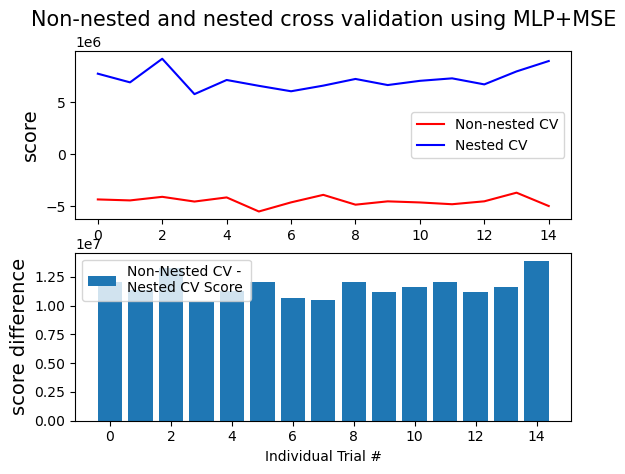

In [51]:
myfig=plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(mnsqrerr_one_cv_layer, color='r')
nested_line, =plt.plot(mnsqrerr_two_cv_layers, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-nested CV", "Nested CV"],
            #bbox_to_anchor=(0, .4, .5, 0),
            loc=0)
plt.title("Non-nested and nested cross validation using MLP+MSE",
          x=.5, y=1.1, fontsize="15")
plt.subplot(212)
difference_plot=plt.bar(range(NoTrials), score_difference[:,0])
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - \nNested CV Score"],
           # bbox_to_anchor=((0.5, 0., 0.2, 0.5)),
            loc=0)
plt.ylabel("score difference", fontsize="14")
plt.show()

## PLS

[sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html)

see also [cross_decomposition from sklearn](https://scikit-learn.org/stable/modules/cross_decomposition.html#cross-decomposition)

Partial Least Squares regression.

PLSRegression is also known as PLS2 or PLS1, depending on the number of targets.

 sklearn.cross_decomposition.PLSRegression(n_components=2, *, scale=True, max_iter=500, tol=1e-06, copy=True)

The parameters are 

* n_components
    + Number of components to keep. Should be in [1, min(n_samples, n_features, n_targets)].
* scale
    + Whether to scale X and Y.
* max_iter
    * The maximum number of iterations of the power method
* tol
    + The tolerance used as convergence criteria in the power method
* copy
    + Whether to copy X and Y in fit before applying centering, and potentially scaling. 

In [52]:
from sklearn import cross_decomposition

start_time = time.time()
# Prepare the CV-result grid
mnsqrerr_one_cv_layer = np.zeros((NoTrials, 1))
mnsqrerr_two_cv_layers = np.zeros((NoTrials, 1))

# Define the grid for CV
p_grid ={
    "n_components": [2,5,10],
    "max_iter": [100, 250, 500],
}

opt_n_components = []
opt_max_iter = []

opt_x_weights_ = []
opt_y_weights_ = []
opt_x_loadings_= []
opt_y_loadings_ = []
opt_x_scores_ = []
opt_y_scores_ = []
r2_sum = 0

for it in range(0, NoTrials):
    print("Sim: {0}".format(it))
    # generate a new random split of the data
    inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=it)
    outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=it)
    
    # define the model
    cv_pls = GSCV(cross_decomposition.PLSRegression(), cv=inner_cv, param_grid=p_grid, n_jobs=n_jobs, scoring=gcv_scorer)
    
    # fit the model
    cv_pls.fit(X = X_train, y = y_train)
    opt_n_components.append(cv_pls.cv_results_['param_n_components'][cv_pls.best_index_])
    opt_max_iter.append(cv_pls.cv_results_['param_max_iter'][cv_pls.best_index_])
    
    # calculate the general prediction accuray
    

    mnsqrerr_one_cv_layer[it] = cv_pls.best_score_
    y_pred_pls = cvp(cv_pls, X=X_test, y=y_test, cv=outer_cv, n_jobs=n_jobs)
    mnsqrerr_two_cv_layers[it] = mean_squared_error(y_test, y_pred_pls)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Sim: 0
Sim: 1


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 2


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 3
Sim: 4


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 5
Sim: 6


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 7


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 8


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 9


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 10


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 11
Sim: 12


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 13


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sim: 14


/home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Execution time: 186.90081906318665 seconds


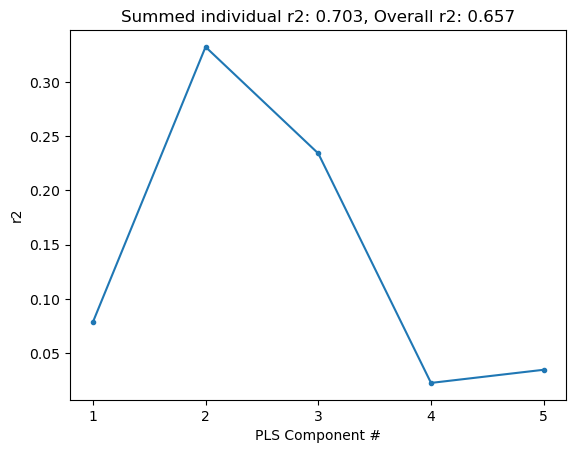

(array([0.07867169, 0.33209977, 0.23406073, 0.02285348, 0.03496263]),
 0.6570814516525302)

In [53]:
# Example Function to generate plots for PLSRegression

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

def pls_explained_variance(pls, X, Y_true, do_plot=True):
    r2 = np.zeros(pls.n_components)
    x_transformed = pls.transform(X) # Project X into low dimensional basis
    for i in range(0, pls.n_components):
        Y_pred = (np.dot(x_transformed[:, i][:, np.newaxis],
                         pls.y_loadings_[:, i][:, np.newaxis].T) * pls._y_std   
                  + pls._y_mean)
        r2[i] = r2_score(Y_true, Y_pred)
        overall_r2 = r2_score(Y_true, pls.predict(X))  # Use all components together.

    if do_plot:
        component = np.arange(pls.n_components) + 1
        plt.plot(component, r2, '.-')
        plt.xticks(component)
        plt.xlabel('PLS Component #'), plt.ylabel('r2')
        plt.title(f'Summed individual r2: {np.sum(r2):.3f}, '
                  f'Overall r2: {overall_r2:.3f}')
        plt.show()

    return r2, overall_r2

# Example usage.
pls = PLSRegression(n_components=5).fit(X_train, y_train)
pls_explained_variance(pls, X_test, y_test)

In [54]:
### Computational Considerations 

# Define the current models: 

model_list = [cv_rf, cvmlp, cv_pls, rf_rnd_results]

# write the models to memory: 
if save_model == True:
    for i in model_list: 
        # Extract model name
        model_name = i.__class__.__name__
        # Construct a filepath
        model_filepath = MODEL_PATH + f"/{model_name}.pkl"
        # Save the model
        joblib.dump(i, model_filepath)
else:
    print("Testrun, no model is written")

# Load the models from memory:

for model in model_list:  
    model_name = model.__class__.__name__  
    model_filepath = MODEL_PATH + f"/{model_name}.pkl"  
    model = joblib.load(model_filepath)  

# Quality Control

In this section the goal is to document the packages which where used during the execution of this notebook

In [55]:
## Package informations
from sklearn import show_versions
show_versions()


System:
    python: 3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:43:22) [GCC 12.3.0]
executable: /home/fhwn.ac.at/202375/.conda/envs/ml_course/bin/python
   machine: Linux-5.15.0-101-generic-x86_64-with-glibc2.31

Python dependencies:
      sklearn: 1.3.1
          pip: 23.2.1
   setuptools: 68.2.2
        numpy: 1.26.0
        scipy: 1.11.3
       Cython: None
       pandas: 2.1.1
   matplotlib: 3.8.0
       joblib: 1.3.2
threadpoolctl: 3.2.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 80
         prefix: libopenblas
       filepath: /home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/libopenblasp-r0.3.24.so
        version: 0.3.24
threading_layer: pthreads
   architecture: SkylakeX

       user_api: openmp
   internal_api: openmp
    num_threads: 80
         prefix: libgomp
       filepath: /home/fhwn.ac.at/202375/.conda/envs/ml_course/lib/libgomp.so.1.0.0
        version: None


#### Time considerations

In [56]:
nb_end_time = time.time()
nb_execution_time = nb_end_time - nb_start_time
print(f"Execution time: {nb_execution_time} seconds")

Execution time: 7351.453875303268 seconds


## Export Notebook

In [57]:
import subprocess
import os

notebook_name = '03_modeling.ipynb' 
# get the current date from the system

# Get the current date
import datetime
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# define the output name 
output_name = f"{notebook_name.split('.')[0]}_{date}.html"

# Convert the notebook to HTML 
subprocess.call(['jupyter', 'nbconvert', '--to', 'html', notebook_name])
# rename the file
os.rename(notebook_name.split('.')[0] + '.html', output_name)

[NbConvertApp] Converting notebook 03_modeling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 1667467 bytes to 03_modeling.html
